# Goal

* default gradient_sim run, but many more taxa (higher pre-fractionation richness)

## Init

In [1]:
import os
import glob
import cPickle as pickle
import copy
import re
import nestly

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [32]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5'
buildDir = os.path.join(workDir, 'richness')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= os.path.join(workDir, 'ampFrags.pkl')
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

bulk_days = [1]

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 80000] # dist, mean, scale, min, max
nprocs = 14

In [33]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('bulk_day', bulk_days)
nest.add('richness_needed', [5000, 10000])

## set params
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('abs', ['5e9'], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [34]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

#-- making DNA pool similar to gradient of interest
echo '# Creating comm file from phyloseq'
phyloseq2comm.r {physeqDir}{physeq_bulkCore} -s 12C-Con -d {bulk_day} > {physeq_bulkCore}_comm.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm.txt

echo '## Adding target taxa to comm file'
comm_add_target.r {physeq_bulkCore}_comm.txt {targetFile} > {physeq_bulkCore}_comm_target.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm_target.txt

echo '# Adding extra richness to community file'
printf "1\t{richness_needed}\n" > richness_needed.txt
comm_add_richness.r {physeq_bulkCore}_comm_target.txt richness_needed.txt > {physeq_bulkCore}_comm_all.txt

echo '## parsing out genome fragments to make simulated DNA pool resembling the gradient of interest'
## all OTUs without an associated reference genome will be assigned a random reference (of the reference genome pool)
### this is done through --NA-random
SIPSim fragment_KDE_parse {fragFile} {physeq_bulkCore}_comm_all.txt \
    --rename taxon_name --NA-random > fragsParsed.pkl


echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    fragsParsed.pkl \
    > fragsParsed_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    fragsParsed_KDE.pkl \
    --np {np} \
    > fragsParsed_KDE_dif.pkl    
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    fragsParsed_KDE_dif.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {physeq_bulkCore}_comm_all.txt \
    --np {np} \
    > fragsParsed_KDE_dif_inc.pkl
 
#echo '# calculating BD shift from isotope incorporation'
#SIPSim BD_shift \
#    fragsComb.pkl \
#    fragsComb_incorp.pkl \
#    --np {np} \
#    > fragsComb_incorp_BD-shift.txt

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {physeq_bulkCore}_comm_all.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    fragsParsed_KDE_dif_inc.pkl \
    {physeq_bulkCore}_comm_all.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
    
echo '# adding count error'
SIPSim OTU_add_error \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_negBin.txt 
    
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub_negBin.txt \
    > OTU_abs{abs}_PCR_sub_negBin_meta.txt

Writing /home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/richness/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun --template-file $bashFile -d richness --log-file log.txt -j 2

2015-12-02 12:57:00,180 * INFO * Template: ./SIPSimRun.sh
2015-12-02 12:57:00,182 * INFO * [44954] Started ./SIPSimRun.sh in richness/1/5000
2015-12-02 12:57:00,184 * INFO * [44955] Started ./SIPSimRun.sh in richness/1/10000


## Plotting number of taxa in each fraction

In [36]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


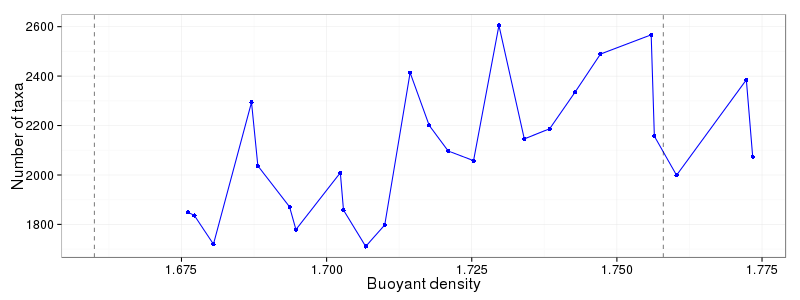

In [37]:
%%R -w 800 -h 300 

## dataframe
df.OTU = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>%    
    gather(sample, abundance, 1:(ncol(df.OTU)-1)) %>%
    group_by(sample) %>%
    summarize(n_taxa = sum(abundance > 0)) %>%
    ungroup()

df.OTU.real = inner_join(df.OTU, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

## plotting
p = ggplot(df.OTU.real, aes(Buoyant_density, n_taxa)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

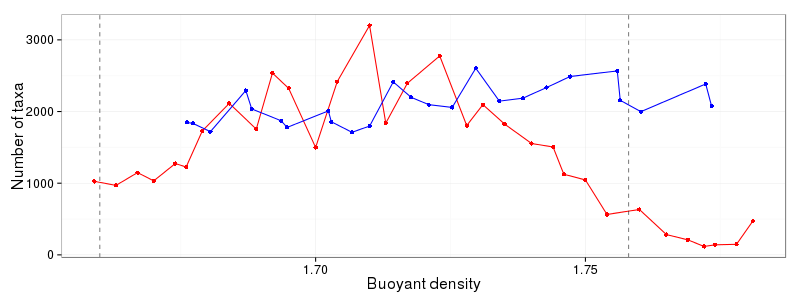

In [43]:
%%R -w 800 -h 300
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/richness/1/10000/'
OTU.table.file = 'OTU_abs5e9_PCR_sub_negBin.txt'

# loading file
F = file.path(OTU.table.dir, OTU.table.file)
df.OTU = read.delim(F, sep='\t')

## edit table
df.OTU.nt = df.OTU %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

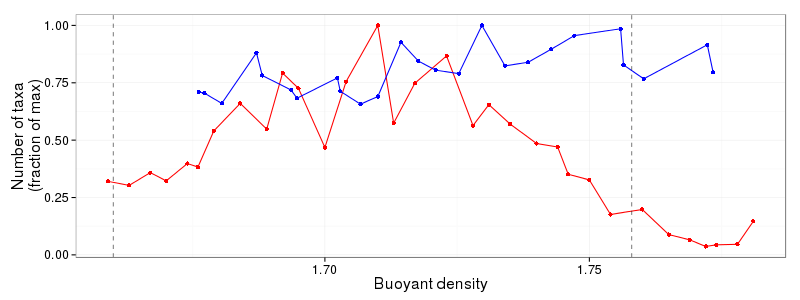

In [44]:
%%R -w 800 -h 300
# normalized by max number of taxa

## edit table
df.OTU.nt = df.OTU.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.OTU.real = df.OTU.real %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.OTU.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.OTU.real, aes(x=Buoyant_density), color='blue') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p